In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='1'></a><br>
# Load and Check Data

In [ ]:
NORMAL = "/content/drive/MyDrive/pneumonia dataset/NORMAL"
PNEUMONIA = "/content/drive/MyDrive/pneumonia dataset/PNEUMONIA"

In [ ]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [ ]:
img_data = []

for i in [NORMAL, PNEUMONIA]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

5856


In [ ]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data)

In [ ]:
data["labels"][0:1583] = 0 # NORMAL
data["labels"][1583:5856] = 1 # PNEUMONIA

<ipython-input-7-db89bdc32fba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:1583] = 0 # NORMAL
<ipython-input-7-db89bdc32fba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][1583:5856] = 1 # PNEUMONIA


In [ ]:
data["labels"] = data["labels"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

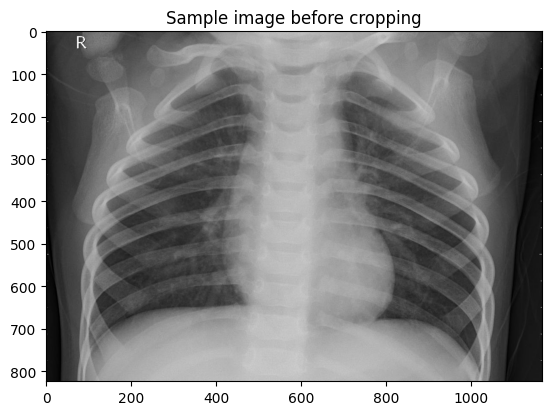

In [ ]:
image = cv.imread(data["img_data"][433])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [ ]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)

<a id='3'></a><br>
# Feature Extraction with NASNetMobile and MobileNet

In [ ]:
from tensorflow.keras.applications import NASNetMobile, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [ ]:
input_shape = (224, 224, 3)
inputs = Input(input_shape)

nas = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
mob = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
multi_net = Concatenate()([GlobalAveragePooling2D()(nas), GlobalAveragePooling2D()(mob)])
model = Model(inputs, multi_net)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 NASNet (Functional)         (None, 7, 7, 1056)           4269716   ['input_1[0][0]']             
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_1[0][0]']             
 onal)                                                                                            
                                                                                                  
 global_average_pooling2d (  (None, 1056)                 0         ['NASNet[0][0]']          

In [ ]:
features_list = []
for i in range(len(img_list)):

    image = img_list[i].reshape(-1, 224, 224, 3)
    features = model.predict(image).reshape(2080,)

    features_list.append(features)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step


In [ ]:
features_df = pd.DataFrame(features_list)

In [ ]:
features_df["labels"] = data["labels"]

In [ ]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [ ]:
x

,0,1,2,3,4,5,6,7,8,9,...,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079
0,0.0,0.511109,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.284426,0.070002,0.000000,0.060026,0.046412,0.629568,2.461580,0.541819,0.000000,0.032134
1,0.0,1.120727,0.0,0.0,0.0,0.022303,0.0,0.000000,0.0,0.0,...,0.653927,0.224488,0.000000,0.000000,0.000000,0.031941,2.739918,0.637392,0.000000,0.075593
2,0.0,2.301416,0.0,0.0,0.0,0.532825,0.0,0.272181,0.0,0.0,...,0.220040,0.226626,0.000000,0.443862,0.121598,1.364938,1.627712,0.803561,0.248594,0.209468
3,0.0,0.839477,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.725479,0.427164,0.000000,0.140796,0.027235,0.163350,1.929134,1.065256,0.000746,0.479313
4,0.0,1.224946,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.836104,0.514064,0.007210,0.345714,0.000000,0.623895,1.808642,1.285045,0.234554,0.303800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,0.0,0.975424,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,2.661455,1.058995,0.073511,0.597687,0.035146,0.153546,2.084452,1.928818,0.318676,1.740999
5852,0.0,1.408919,0.0,0.0,0.0,1.089845,0.0,0.000000,0.0,0.0,...,2.003151,0.485871,0.057567,0.674254,0.090078,0.089591,2.373462,1.179824,0.000000,0.373868
5853,0.0,0.636795,0.0,0.0,0.0,0.807727,0.0,0.000000,0.0,0.0,...,1.021941,0.670307,0.000000,0.000000,0.664598,0.354822,3.126692,1.375212,0.000000,0.016295
5854,0.0,1.886134,0.0,0.0,0.0,0.072660,0.0,0.000000,0.0,0.0,...,0.618421,1.079426,0.000000,0.868508,0.032947,0.358759,2.649492,0.647073,0.013430,0.857470


In [ ]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2080


In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

<a id='4'></a><br>
# Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [ ]:
x_ = pd.DataFrame(x_)

<a id='5'></a><br>
# Feature Selection Methods

<a id='8'></a><br>
## Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x.loc[:,embeded_rf_support].columns.tolist()

    rf_x = x[embeded_rf_feature]
    return rf_x

In [ ]:
fs_x = rf_fs() # feature selection methods "rf_fs"

In [ ]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 1546


<a id='9'></a><br>
# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [ ]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.8924914675767918 with K = 5


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.5f' % (knn_score_))

Accuracy : 0.89249


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       341
           1       0.93      0.92      0.92       831

    accuracy                           0.89      1172
   macro avg       0.87      0.87      0.87      1172
weighted avg       0.89      0.89      0.89      1172



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.89249 Precision: 0.92521  Recall: 0.92298 Error Rate: 0.10751 F1 Score: 0.92410 AUC Score: 0.87058


Confusion matrix, without normalization
[[279  62]
 [ 64 767]]


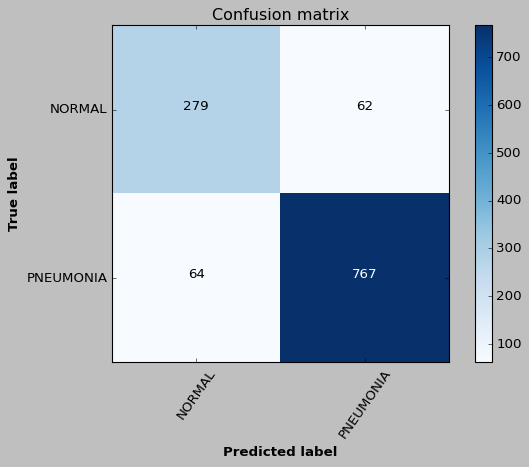

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test, predicted)


cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')
plt.savefig('CM1',dpi=400)

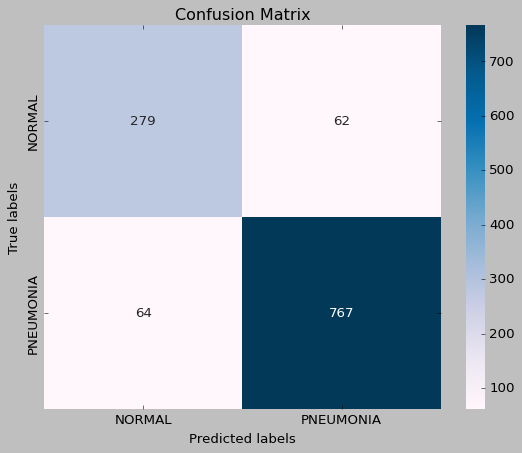

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap1',dpi=400)
plt.show()

<ipython-input-31-c6c642de1969>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


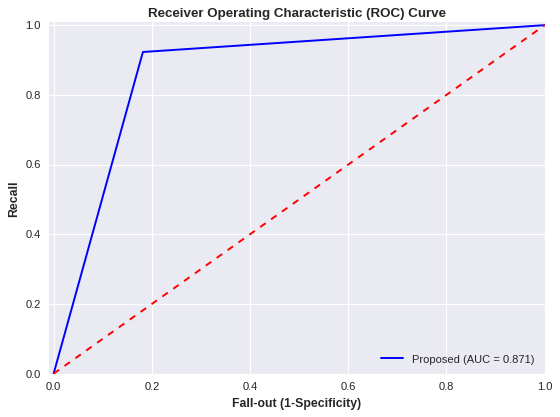

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve1',dpi=400)
plt.show()

In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

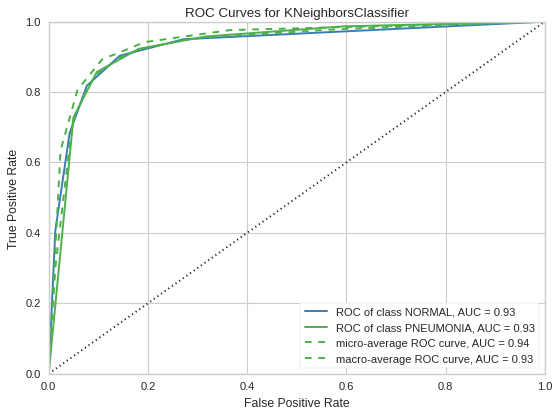

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
visualizer = ROCAUC(knn, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
plt.savefig('ROC curve1',dpi=400)
visualizer.show()

<a id='12'></a><br>
## SVM

In [ ]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [ ]:
print(SVM_grid.best_params_)

print(SVM_grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)


In [ ]:
svm_clf = svm.SVC(C=1000, gamma=0.0001, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.5f' % (svm_score_))

Accuracy : 0.94881


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.94881 Precision: 0.95621  Recall: 0.97232 Error Rate: 0.05119 F1 Score: 0.96420 AUC Score: 0.93191


Confusion matrix, without normalization
[[304  37]
 [ 23 808]]


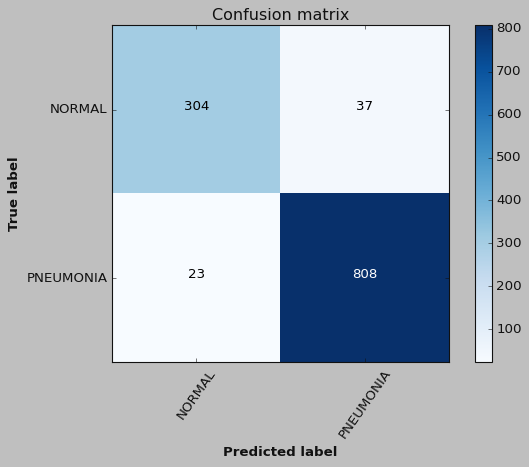

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test, predicted)


cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')
plt.savefig('CM22',dpi=400)

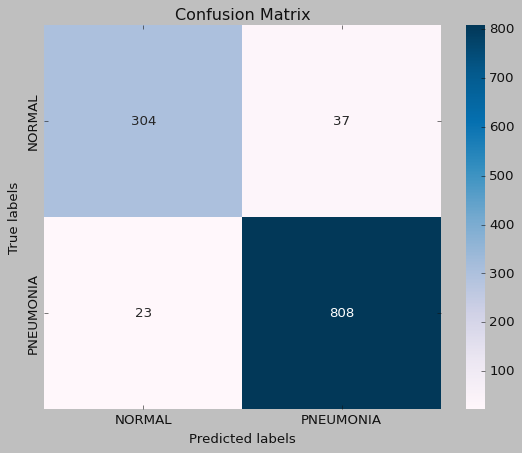

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap22',dpi=400)
plt.show()

<ipython-input-45-a2ce98955347>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


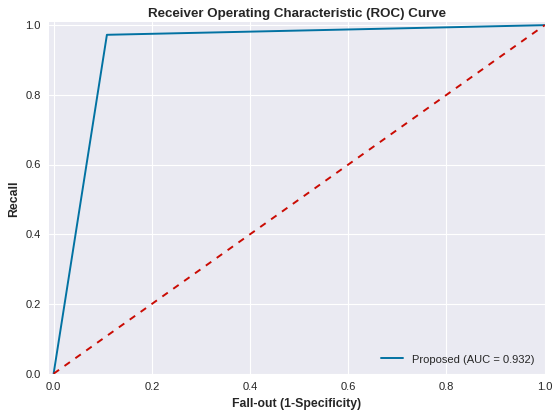

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve22',dpi=400)
plt.show()

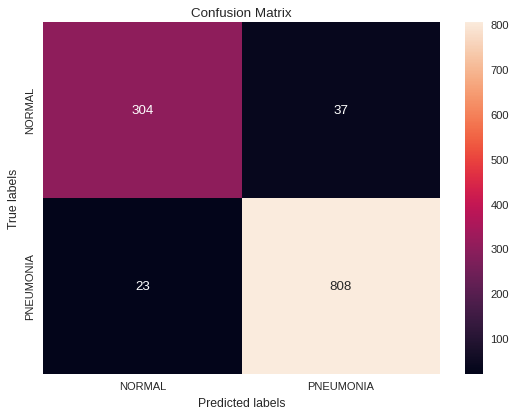

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap23',dpi=400)
plt.show()

<a id='13'></a><br>
## Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [ ]:
print(RF_grid.best_params_)

In [ ]:
r_forest = RandomForestClassifier(500,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.5f' % (rf_score_))

Accuracy : 0.93345


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       341
           1       0.93      0.98      0.95       831

    accuracy                           0.93      1172
   macro avg       0.94      0.90      0.92      1172
weighted avg       0.93      0.93      0.93      1172



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.93345 Precision: 0.93127  Recall: 0.97834 Error Rate: 0.06655 F1 Score: 0.95423 AUC Score: 0.90119


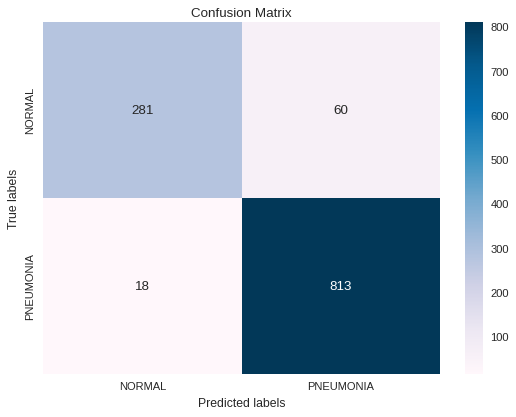

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap4',dpi=400)
plt.show()

<ipython-input-51-35c6ec2c20cc>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


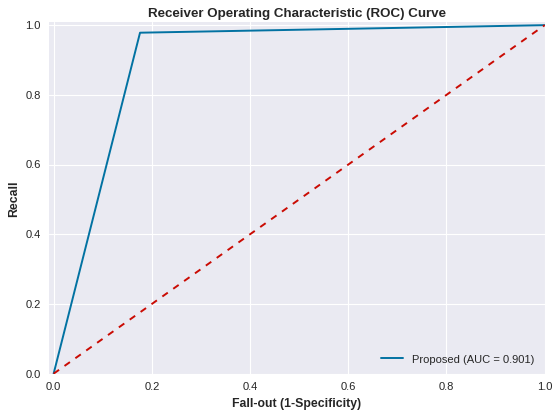

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve4',dpi=400)
plt.show()

<a id='14'></a><br>
## Naive Bayes

In [ ]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)
nb_score_ = np.mean(score)

print('Accuracy : %.5f' % (nb_score_))

Accuracy : 0.87116


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       341
           1       0.94      0.88      0.91       831

    accuracy                           0.87      1172
   macro avg       0.84      0.87      0.85      1172
weighted avg       0.88      0.87      0.87      1172



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.87116 Precision: 0.93702  Recall: 0.87726 Error Rate: 0.12884 F1 Score: 0.90615 AUC Score: 0.86678


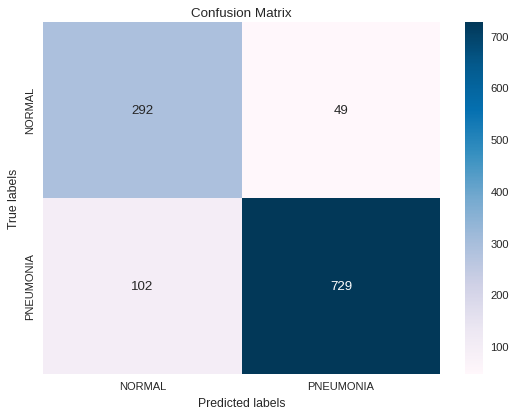

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap5',dpi=400)
plt.show()

<ipython-input-56-abdb76e5e069>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


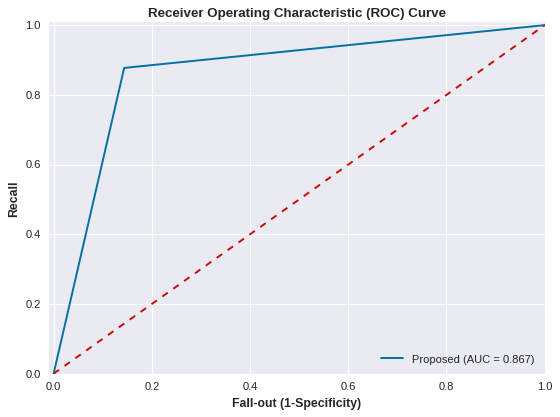

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve5',dpi=400)
plt.show()

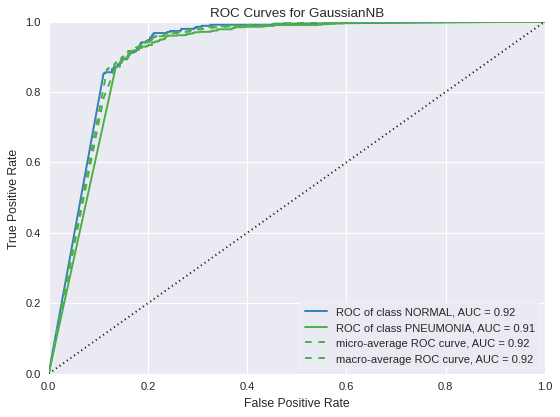

<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
visualizer = ROCAUC(nb_model, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
plt.savefig('ROC curve5',dpi=400)
visualizer.show()